# 4 Modeling: Breast Cancer Gene Expressions

## 4.1 Contents
* [4 Modeling](#4_modeling)
    * [4.1 Contents](#4.1_contents)
    * [4.2 Introduction](#4.2_intro)
    * [4.3 Imports](#4.3_imports)
    * [4.4 Loading the Data](#4.4_loading)

## 4.2 Introduction

## 4.3 Imports

In [1]:
# data manipulation and math
#
import numpy as np
import scipy as sp
import pandas as pd
#
# plotting and visualization
#
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
#
import seaborn as sns
#
# modeling
#
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder as OHE
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
#
from sklearn.cluster import KMeans


#classifiers
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import pickle
import time 
print("Loaded Libraries")

Loaded Libraries


## 4.4 Loading the Data

In [2]:
# Load the NumPy arrays from the pickle files
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_train_190.pkl', 'rb') as file:
    X_train_190 = pickle.load(file)
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_test_190.pkl', 'rb') as file:
    X_test_190 = pickle.load(file)  
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_train_360.pkl', 'rb') as file:
    X_train_360 = pickle.load(file)  
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_test_360.pkl', 'rb') as file:
    X_test_360 = pickle.load(file) 
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_train_full.pkl', 'rb') as file:
    X_train_full = pickle.load(file) 

with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\X_test_full.pkl', 'rb') as file:
    X_test_full = pickle.load(file) 
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\y_train.pkl', 'rb') as file:
    y_train = pickle.load(file) 
    
with open(r'C:\Users\leann\OneDrive\Desktop\SPRINGBOARD\capstone 2\exports\y_test.pkl', 'rb') as file:
    y_test = pickle.load(file) 

## Unsupervised approach: K Means clustering

I want to take a peek at our data via K Means Clustering to see if we see anything meaningful. 

In [3]:
# write a function to fit, predict and plot for KMeans

def KMeans_fit_predict_plot(X_train, X_test, title):
    model = KMeans(n_clusters=2)
    model.fit(X_train)

    labels = model.predict(X_test)
    centroids = model.cluster_centers_

    centroids_x = centroids[:,0]
    centroids_y = centroids[:,1]

    xs = X_test[:,0]
    ys = X_test[:,1]
    plt.scatter(xs, ys, c=labels)

    plt.scatter(centroids_x, centroids_y, marker='D', s=50)
    plt.title(title)
    plt.show()

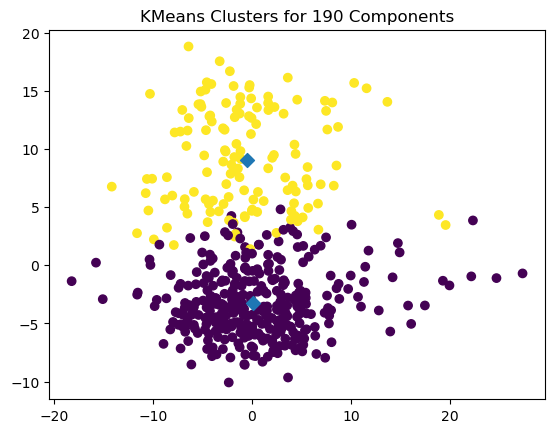

In [4]:
KMeans_fit_predict_plot(X_train_190, X_test_190, 'KMeans Clusters for 190 Components')


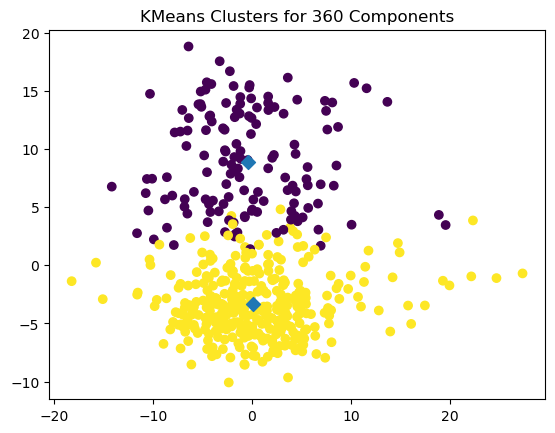

In [5]:
KMeans_fit_predict_plot(X_train_360, X_test_360, 'KMeans Clusters for 360 Components')

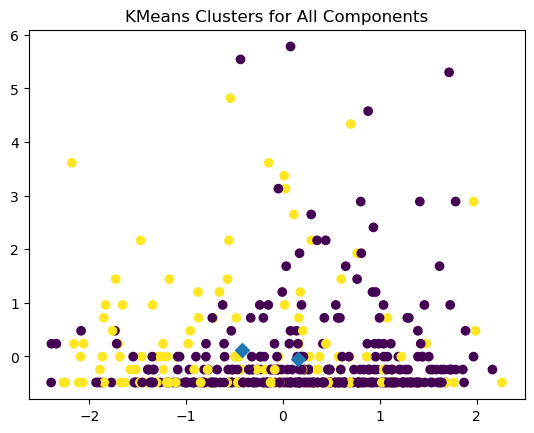

In [6]:
KMeans_fit_predict_plot(X_train_full, X_test_full, 'KMeans Clusters for All Components')

NOTE: I don't really know what to do with this, but the first two plots with PCA look about the same and show clear clusters, and when I look at the whole data set I don't see a pattern. 

## Picking up where we left off on the last notebook...



I want to easily be able to compare all of the results, so I will append them to an empty I'm creating now dataframe, results_df:

In [7]:
results_df = pd.DataFrame(columns=['Model', 'Mean CV F1 Score', 'F1 Pos Class Score'] )

### First, this was my Logistic Regression base model, for the full dataframe (no pca)

In [8]:
lr_model_full = LogisticRegression(solver = 'newton-cg', max_iter = 500) 
lr_model_full.fit(X_train_full,y_train)
y_predict_test_full = lr_model_full.predict(X_test_full)

scores = cross_val_score(lr_model_full, X_train_full, y_train, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.40201005 0.41081081 0.42328042 0.46766169 0.46700508]
Mean CV F1 score for the positive class: 0.43 (+/- 0.06)


In [9]:
#classification report: 

print(classification_report(y_test, y_predict_test_full))

              precision    recall  f1-score   support

           0       0.74      0.71      0.72       320
           1       0.45      0.48      0.46       156

    accuracy                           0.63       476
   macro avg       0.59      0.60      0.59       476
weighted avg       0.64      0.63      0.64       476



In [28]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Logistic Regression Base Model', 'Mean CV F1 Score': scores.mean(), 'F1 Pos Class Score':0.46}])
results_df = pd.concat([results_df, new_results], ignore_index=True)


results_df.head()

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression,0.434154,0.64
1,"Logistic Regression, Tuned",0.414950,0.84
2,Logistic Regression,0.414950,0.46
3,"Logistic Regression, Tuned",0.413011,0.67
4,Logistic Regression Base Model,0.413011,0.46


### CROSS VALIDATION AND HYPERPARAMETER TUNING

In [11]:
# Define function to come up with cross validation scores: QUESTION - is this necessary or can I just use cross_val_score()?
def cv_score(clf, x, y, score_func = f1_score):
    result = 0
    nfold = 5
    x.reset_index(drop = True, inplace = True)
    y.index = x.index
    for train, test in KFold(nfold, shuffle = True,
                             random_state = 42).split(x):
        clf.fit(x.loc[train, :], y[train])
        result += score_func(clf.predict(x.loc[test, :]), y[test])
    return result / nfold

In [12]:
# Convert X_train_190 and y_train to pandas DataFrames
X_train_190_df = pd.DataFrame(X_train_190)
y_train_df = pd.Series(y_train)
X_test_190_df = pd.DataFrame(X_test_190)
y_test_df=pd.Series(y_test)

# Convert X_train_360 to pandas DataFrame
X_train_360_df = pd.DataFrame(X_train_360)
X_test_360_df = pd.DataFrame(X_test_360)

# Convert X_train_full to pandas DataFrame
X_train_full_df = pd.DataFrame(X_train_full)
X_test_full_df = pd.DataFrame(X_test_full)

In [13]:
# use the cv_score function

clf190 = LogisticRegression(solver = 'liblinear', max_iter = 500)
score = cv_score(clf190, X_train_190_df, y_train_df)
print('cv_score for 190 components:',f'{score:.2f}')

clf360 = LogisticRegression(solver = 'liblinear', max_iter = 500)
score = cv_score(clf360, X_train_360_df, y_train_df)
print('cv_score for 360 components:',f'{score:.2f}')

clffull = LogisticRegression(solver = 'liblinear', max_iter = 500)
score = cv_score(clffull, X_train_full_df, y_train_df)
print('cv_score for ALL components:',f'{score:.2f}')

cv_score for 190 components: 0.43
cv_score for 360 components: 0.43
cv_score for ALL components: 0.41


In [14]:
# Hyperparameter tuning using grid search

params={
    'penalty':['l1','l2'],
    'C':[0.001, 0.1, 1, 10, 100],
    }

# instantiate the model
logreg = LogisticRegression(solver='liblinear')

#  do GridSearchCV
grid_search= GridSearchCV(estimator=logreg,param_grid=params,cv=5, scoring='f1', n_jobs=-1)

# 190 COMPONENTS
grid_search.fit(X_train_190,y_train)

# print best hyperparameters and F1 score
print("Best hyperparameters for 190 components:", grid_search.best_params_)
print("Accuracy score for 190 components:", grid_search.best_score_)

# 360 COMPONENTS
grid_search.fit(X_train_360,y_train)

# print best hyperparameters and F1 score
print("\nBest hyperparameters for 360 components:", grid_search.best_params_)
print("F1 score for 360 components:", grid_search.best_score_)

# ALL COMPONENTS
grid_search.fit(X_train_full,y_train)

# print best hyperparameters and F1 score
print("\nBest hyperparameters for NO PCA", grid_search.best_params_)
print("F1 score for All components:", grid_search.best_score_)

Best hyperparameters for 190 components: {'C': 0.001, 'penalty': 'l2'}
Accuracy score for 190 components: 0.5268923738750964

Best hyperparameters for 360 components: {'C': 0.001, 'penalty': 'l2'}
F1 score for 360 components: 0.5497001573100995

Best hyperparameters for NO PCA {'C': 0.001, 'penalty': 'l2'}
F1 score for All components: 0.5518635896021892


### Logistic Regression with new hyperparamters:

### 190 components:

In [15]:
#190 components
logreg190=LogisticRegression(solver = 'liblinear', max_iter = 500, C=0.001, penalty='l2')
logreg190.fit(X_train_190,y_train)

#find the F1 score with cv_score that is defined above
score = cv_score(logreg190,X_test_190_df,y_test_df)
print(f"CV F1 score test data for 190 components: {score:.2f}")

# predict for 190
y_predict_test_190_tuned = logreg190.predict(X_test_190)
y_predict_training_190_tuned = logreg190.predict(X_train_190)

# Training classification report, 190 components: 
print('\nTraining data, 190 Components:\n',classification_report(y_train,y_predict_training_190_tuned))


# Testing classification report, 190 components: 
print('\nTesting data, 190 Components:\n',classification_report(y_test,y_predict_test_190_tuned))

CV F1 score test data for 190 components: 0.46

Training data, 190 Components:
               precision    recall  f1-score   support

           0       0.78      0.66      0.71       961
           1       0.47      0.62      0.53       466

    accuracy                           0.65      1427
   macro avg       0.63      0.64      0.62      1427
weighted avg       0.68      0.65      0.66      1427


Testing data, 190 Components:
               precision    recall  f1-score   support

           0       0.84      0.74      0.79       320
           1       0.57      0.70      0.63       156

    accuracy                           0.73       476
   macro avg       0.70      0.72      0.71       476
weighted avg       0.75      0.73      0.73       476



with our untuned model, for 190 components our test set had a f1 score of 0.63 for 1, and 0.79 for 0, which is better

In [30]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Logistic Regression, Tuned (190 Comp)', 'Mean CV F1 Score': scores.mean(), 'F1 Pos Class Score':0.63}])
results_df = pd.concat([results_df, new_results], ignore_index=True)


results_df.head()

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression,0.434154,0.64
1,"Logistic Regression, Tuned",0.414950,0.84
2,Logistic Regression,0.414950,0.46
3,"Logistic Regression, Tuned",0.413011,0.67
4,Logistic Regression Base Model,0.413011,0.46


### 360 Components

In [16]:
#360 components
logreg360=LogisticRegression(solver = 'liblinear', max_iter = 500, C=0.001, penalty='l2')
logreg360.fit(X_train_360,y_train)

#find the accuracy score with cv_score that is defined above
score = cv_score(logreg360,X_test_360_df,y_test_df)
print(f" CV F1 score test data for 360 components: {score:.2f}")

# predict for 360
y_predict_test_360_tuned = logreg360.predict(X_test_360)
y_predict_training_360_tuned = logreg360.predict(X_train_360)

# Training classification report, 360 components: 
print('\nTraining data, 360 Components:\n',classification_report(y_train,y_predict_training_360_tuned))


# Testing classification report, 360 components: 
print('\nTesting data, 360 Components:\n',classification_report(y_test,y_predict_test_360_tuned))

 CV F1 score test data for 360 components: 0.45

Training data, 360 Components:
               precision    recall  f1-score   support

           0       0.77      0.65      0.71       961
           1       0.46      0.61      0.52       466

    accuracy                           0.64      1427
   macro avg       0.62      0.63      0.61      1427
weighted avg       0.67      0.64      0.65      1427


Testing data, 360 Components:
               precision    recall  f1-score   support

           0       0.85      0.77      0.81       320
           1       0.60      0.72      0.66       156

    accuracy                           0.75       476
   macro avg       0.73      0.75      0.73       476
weighted avg       0.77      0.75      0.76       476



with our untuned model, for 190 components our test set had a f1 score of 0.62 for 1, and 0.81 for 0. However, there is less overfitting happening now. 

### All Components

In [17]:
#all  components
logregfull=LogisticRegression(solver = 'liblinear', max_iter = 500, C=0.1, penalty='l1')
logregfull.fit(X_train_full,y_train)

#find the accuracy score with cv_score that is defined above
score = cv_score(logregfull,X_test_full_df,y_test_df)
print(f"CV F1 score test data for full components: {score:.2f}")

# predict for full
y_predict_test_full_tuned = logregfull.predict(X_test_full)
y_predict_training_full_tuned = logregfull.predict(X_train_full)

# Training classification report, full components: 
print('\nTraining data, full Components:\n',classification_report(y_train,y_predict_training_full_tuned))


# Testing classification report, full components: 
print('\nTesting data, full Components:\n',classification_report(y_test,y_predict_test_full_tuned))

CV F1 score test data for full components: 0.41

Training data, full Components:
               precision    recall  f1-score   support

           0       0.74      0.85      0.79       961
           1       0.55      0.37      0.45       466

    accuracy                           0.70      1427
   macro avg       0.64      0.61      0.62      1427
weighted avg       0.68      0.70      0.68      1427


Testing data, full Components:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87       320
           1       0.80      0.58      0.67       156

    accuracy                           0.81       476
   macro avg       0.81      0.75      0.77       476
weighted avg       0.81      0.81      0.80       476



In [23]:
# Do cross validation like I did everywhere else to get values to add to results:

scores = cross_val_score(logregfull, X_train_full, y_train, cv=5, scoring='f1')
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Logistic Regression, Tuned', 'Mean CV F1 Score': scores.mean(), 'F1 Pos Class Score':0.67 }])
results_df = pd.concat([results_df, new_results], ignore_index=True)


In [24]:
results_df.head()

,Model,Mean CV F1 Score,F1 Pos Class Score
0,Logistic Regression,0.434154,0.64
1,"Logistic Regression, Tuned",0.414950,0.84
2,Logistic Regression,0.414950,0.46
3,"Logistic Regression, Tuned",0.413011,0.67


with our untuned model, for all components our test set had a f1 score of 0.64 for 1, and 0.82 for 0. There is also less overfitting here.

<b>CONCLUSION: </b>The best logistic regression model for predicting cancer is the one with no PCA.


### Precision Recall (PR) Curve

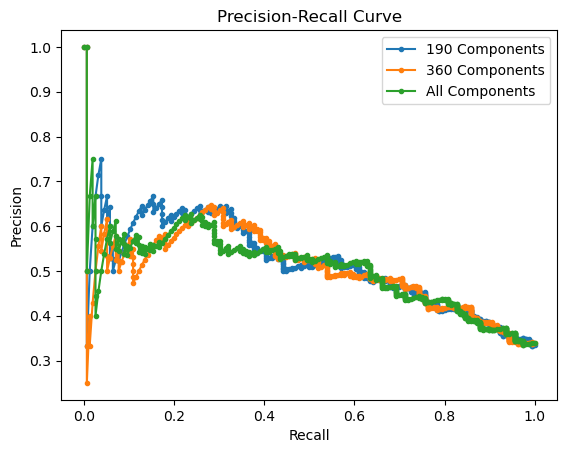

In [20]:
# Define models with their respective hyperparameters
models = {
    '190 Components': LogisticRegression(solver = 'liblinear', max_iter = 500, C=0.001, penalty='l2'),
    '360 Components': LogisticRegression(solver = 'liblinear', max_iter = 500, C=0.001, penalty='l2'),
    'All Components': LogisticRegression(solver = 'liblinear', max_iter = 500, C=0.1, penalty='l1')
}

# Define your training data
training_data = {
    '190 Components': X_train_190,
    '360 Components': X_train_360,
    'All Components': X_train_full
}

# Define your testing data
testing_data = {
    '190 Components': X_test_190,
    '360 Components': X_test_360,
    'All Components': X_test_full
}

for name, model in models.items():
    # Train 
    model.fit(training_data[name], y_train)
    
    # Predict
    y_scores = model.predict_proba(testing_data[name])[:, 1]
    
    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_scores)

    plt.plot(recall, precision, marker='.', label=name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


### Confusion Matrix

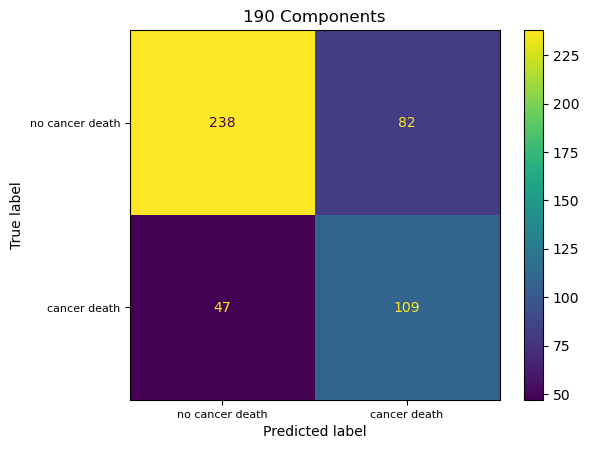

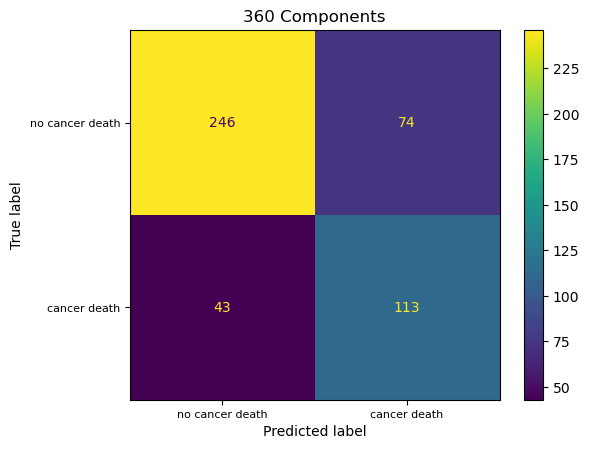

NameError: name 'clf_full' is not defined

In [21]:
# 190 components:

cm = confusion_matrix(y_test, y_predict_test_190_tuned, labels = clf190.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no cancer death', 'cancer death'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no cancer death', 'cancer death'], fontsize = 8)
ax.set_yticklabels(labels = ['no cancer death', 'cancer death'], fontsize = 8)
plt.title('190 Components')
display_cm.plot(ax = ax)
plt.show();

# 360 components:

cm = confusion_matrix(y_test, y_predict_test_360_tuned, labels = clf360.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no cancer death', 'cancer death'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no cancer death', 'cancer death'], fontsize = 8)
ax.set_yticklabels(labels = ['no cancer death', 'cancer death'], fontsize = 8)
plt.title('360 Components')
display_cm.plot(ax = ax)
plt.show();

# full data set (no PCA)
cm = confusion_matrix(y_test, y_predict_test_full_tuned, labels = clf_full.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no cancer death', 'cancer death'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no cancer death', 'cancer death'], fontsize = 8)
ax.set_yticklabels(labels = ['no cancer death', 'cancer death'], fontsize = 8)
plt.title('No PCA')
display_cm.plot(ax = ax)
plt.show();

And again here, our data with no PCA perform the best.

# Random Forest Classifier Model

<b>For all components (no pca)</b>

In [ ]:
# Create the model
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rfc.fit(X_train_full, y_train)

# Predict the labels of the test set
y_predict_test_full_rf = rfc.predict(X_test_full)

# Print the classes
print(rfc.classes_)

# Test classification report, all components: 
print('Random Forest Model: Test data, all Components:\n',classification_report(y_test,y_predict_test_full_rf))


<b>Cross validation/adding to results.df:<b/>

In [ ]:
scores = cross_val_score(rfc, X_train_full, y_train, cv=5, scoring='f1')
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Random Forest', 'Mean CV F1 Score': scores.mean(),'F1 Pos Class Score':0.63}])
results_df = pd.concat([results_df, new_results], ignore_index=True)

In [ ]:
results_df.head()

<b> Hyperparameter Tuning</b>

doing this: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [ ]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
params = rfc.get_params()
for param_name in params:
    print(f'{param_name} : {params[param_name]}')

In [ ]:
# Define the parameter grid - QUESTION - HOW DO I KNOW WHICH OPTIONS TO SEARCH OVER?
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create a base model
rfc = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                           cv = 5, scoring='f1', n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train_190, y_train)

# Get the best parameters
print(grid_search.best_params_)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV - 

# SHOULD I DO THIS OR WHAT I DID ABOVE, OR BOTH?

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


In [ ]:
start_time = time.time()

In [ ]:
# Use the random grid to search for best hyperparameters

# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring='f1')
# Fit the random search model
rfc_random.fit(X_train_full, y_train)

In [ ]:
end_time = time.time()

print("Execution Time:", end_time - start_time, "seconds")

In [ ]:
print('best params:',rfc_random.best_params_ )

In [ ]:
print('best score:',rfc_random.best_score_)

In [ ]:
#To determine if random search yielded a better model, we compare the base model with the best random search model.
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    print('Model Performance')
    print(classification_report(test_labels, predictions))

base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train_full, y_train)
base_performance = evaluate(base_model, X_test_full, y_test)

best_random = rfc_random.best_estimator_
random_performance = evaluate(best_random, X_test_full, y_test)

In [ ]:
scores = cross_val_score(best_random, X_train_full, y_train, cv=5, scoring='f1')
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'Random Forest, random tuning', 'Mean CV F1 Score': scores.mean(), 'F1 Pos Class Score':0.67}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df.head()

In [ ]:
# also try grid search with cross validation to see if we can get something better. 

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rfc = RandomForestClassifier(random_state=42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                           cv = 5, scoring='f1', n_jobs = -1, verbose = 2)


In [ ]:
start_time = time.time()

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train_full, y_train)

# Get the best parameters and the best estimator
print('Best parameters:\n',grid_search.best_params_)
best_grid = grid_search.best_estimator_

# Predict the labels of the test set
y_predict_test_full_rf_gs = best_grid.predict(X_test_full)

# Print the classification report for the test data
print('Test Classification Report:\n',classification_report(y_test, y_predict_test_full_rf_gs))

# Evaluate the improvement
base_accuracy = f1_score(y_test, y_predict_test_full_rf, average='weighted')
grid_accuracy = f1_score(y_test, y_predict_test_full_rf_gs, average='weighted')

print('Base F1 score: ', base_accuracy)
print('Grid Search F1 score: ', grid_accuracy)
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))


In [ ]:
end_time = time.time()
print("Execution Time:", end_time - start_time, "seconds")

My base model had the best performance.

In [ ]:
# Cross validation of base model:

scores = cross_val_score(rfc, X_train_full, y_train, cv=5, scoring='f1')
print(scores)

print("Mean F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
#Random forest classifier base model CONFUSION MATRIX

# define the labels, as it is throwing an error when I use it directly
#labels=rfc.classes_
# full data set (no PCA)
cm = confusion_matrix(y_test, y_predict_test_full_rf, labels = rfc.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no cancer death', 'cancer death'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no cancer death', 'cancer death'], fontsize = 8)
ax.set_yticklabels(labels = ['no cancer death', 'cancer death'], fontsize = 8)
plt.title('No PCA')
display_cm.plot(ax = ax)
plt.show();

In [ ]:
cm = confusion_matrix(y_test, xgboost_y_pred_full, labels = xgboost_model.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no cancer death', 'cancer death'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no cancer death', 'cancer death'], fontsize = 8)
ax.set_yticklabels(labels = ['no cancer death', 'cancer death'], fontsize = 8)
plt.title('No PCA')
display_cm.plot(ax = ax)
plt.show();

This looks terrible. 

# XG Boost Model

In [ ]:
# BASE MODEL
# fit model no training data
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train_full, y_train)

In [ ]:

# make predictions for test data
xgboost_y_pred_full = xgboost_model.predict(X_test_full)
#predictions = [round(value) for value in xgboost_y_pred_full]


In [ ]:
f1_score = f1_score(y_test, xgboost_y_pred_full)
print("F1 score: %.2f%%" % (f1_score * 100.0))

In [ ]:
print('Test Classification Report, XG Boost Base Model w/ Full Data Set:\n',classification_report(y_test, xgboost_y_pred_full))

In [ ]:
# Cross validation of base model:

scores = cross_val_score(xgboost_model, X_train_full, y_train, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
# Append the results to the DataFrame containing all of the results:
new_results = pd.DataFrame([{'Model': 'XGBoost', 'Mean CV F1 Score': scores.mean(), 'F1 Pos Class Score':0.74}])
results_df = pd.concat([results_df, new_results], ignore_index=True)
results_df.head()

In [ ]:
#LGM base model CONFUSION MATRIX

# full data set (no PCA)
cm = confusion_matrix(y_test, xgboost_y_pred_full, labels = xgboost_model.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no cancer death', 'cancer death'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no cancer death', 'cancer death'], fontsize = 8)
ax.set_yticklabels(labels = ['no cancer death', 'cancer death'], fontsize = 8)
plt.title('No PCA')
display_cm.plot(ax = ax)
plt.show();

# LGBM Classifier

In [ ]:
# using this method: https://machinelearningmastery.com/light-gradient-boosted-machine-lightgbm-ensemble/

#create the model

lgbm_model_full = LGBMClassifier()


In [ ]:
scores = cross_val_score(lgbm_model_full, X_train_full, y_train, cv=5, scoring='f1')
print(scores)

print("Mean CV F1 score for the positive class: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

### ROC and AUC curves
Calculate predicted probabilities of cancer death from logistic regression model:

In [ ]:
y_prob_190 = clf190.predict_proba(X_test_190)[:, 1]
y_prob_360 = clf360.predict_proba(X_test_360)[:, 1]


Calculate false positive rate and true positive rate using roc_curve function:

In [ ]:
fpr_190, tpr_190, thresholds_190 = roc_curve(y_test, y_prob_190)
fpr_360, tpr_360, thresholds_360 = roc_curve(y_test, y_prob_360)

In [ ]:
Calculate AUC (area under the curve):

In [ ]:
auc_190 = auc(fpr_190, tpr_190)
auc_360 = auc(fpr_360, tpr_360)
print('AUC_190:',auc_190)
print('AUC_360:',auc_360)

In [ ]:
Plot ROC curves:

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_190, tpr_190, label='190 components (AUC = {:.2f})'.format(auc_190))
plt.plot(fpr_360, tpr_360, label='360 components (AUC = {:.2f})'.format(auc_360))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

So far it is clear that the  190 components performs better with logistic regression. 

<b> Training vs Test Accuracy for 360 components </b>

In [ ]:
# Define lists to store evaluation metrics
training_accuracy = []
test_accuracy = []
accuracy_difference = []

# Define the number of trials
n_splits = 25

# Define the LogisticRegression object
clf360 = LogisticRegression(solver='newton-cg', max_iter=500)

# Loop over multiple trials
for i in range(n_splits):
    # Perform a split for this iteration, using the same random_state
    Xlr, Xtestlr, ylr, ytestlr = train_test_split(X_train_360, y_train, stratify=y_train, random_state=i)
    
    # Fit the classifier on the training set
    clf360.fit(Xlr, ylr)
    
    # Predict the labels for the training data
    y_predict_training = clf360.predict(Xlr)
    
    # Predict the labels for the test data
    y_predict_test = clf360.predict(Xtestlr)
    
    # Save training set accuracy for this split
    tr_accuracy = accuracy_score(y_predict_training, ylr)
    training_accuracy.append(tr_accuracy)
    
    # Save test set accuracy for this split
    tst_accuracy = accuracy_score(y_predict_test, ytestlr)
    test_accuracy.append(tst_accuracy)
    
    # Save difference between the two accuracy values
    accuracy_difference.append(tst_accuracy - tr_accuracy)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(range(len(training_accuracy)),
           training_accuracy, 
           color = 'blue', 
           alpha = 0.5,
           label = 'Train data results')
ax.plot(range(len(training_accuracy)),
        training_accuracy, 
        color = 'blue', 
        linestyle = '-.',
        linewidth = 0.5)
ax.scatter(range(len(test_accuracy)),
           test_accuracy, 
           color = 'red', 
           alpha = 0.35, 
           label = 'Test data results')
ax.plot(range(len(test_accuracy)),
        test_accuracy, 
        color = 'red', 
        linestyle = '-.',
        linewidth = 0.5)
ax.legend(fontsize = 8, loc = "lower right")
ax.set_ylabel('Training vs Test Accuracy')
ax.set_ylim(0, 1)
ax.set_xlabel('trial number')
ax.set_title ('Training vs Test Accuracy for 360 components')
plt.show()

### Training vs Test Accuracy for All Components

In [ ]:
# Define lists to store evaluation metrics
training_accuracy = []
test_accuracy = []
accuracy_difference = []

# Define the number of trials
n_splits = 25

# Define the LogisticRegression object
clf_full = LogisticRegression(solver='newton-cg', max_iter=500)

# Loop over multiple trials
for i in range(n_splits):
    # Perform a split for this iteration, using the same random_state
    Xlr, Xtestlr, ylr, ytestlr = train_test_split(X_train_full, y_train, stratify=y_train, random_state=i)
    
    # Fit the classifier on the training set
    clf_full.fit(Xlr, ylr)
    
    # Predict the labels for the training data
    y_predict_training = clf_full.predict(Xlr)
    
    # Predict the labels for the test data
    y_predict_test = clf_full.predict(Xtestlr)
    
    # Save training set accuracy for this split
    tr_accuracy = accuracy_score(y_predict_training, ylr)
    training_accuracy.append(tr_accuracy)
    
    # Save test set accuracy for this split
    tst_accuracy = accuracy_score(y_predict_test, ytestlr)
    test_accuracy.append(tst_accuracy)
    
    # Save difference between the two accuracy values
    accuracy_difference.append(tst_accuracy - tr_accuracy)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(range(len(training_accuracy)),
           training_accuracy, 
           color = 'blue', 
           alpha = 0.5,
           label = 'Train data results')
ax.plot(range(len(training_accuracy)),
        training_accuracy, 
        color = 'blue', 
        linestyle = '-.',
        linewidth = 0.5)
ax.scatter(range(len(test_accuracy)),
           test_accuracy, 
           color = 'red', 
           alpha = 0.35, 
           label = 'Test data results')
ax.plot(range(len(test_accuracy)),
        test_accuracy, 
        color = 'red', 
        linestyle = '-.',
        linewidth = 0.5)
ax.legend(fontsize = 8, loc = "lower right")
ax.set_ylabel('Training vs Test Accuracy')
ax.set_ylim(0, 1)
ax.set_xlabel('trial number')
ax.set_title ('Training vs Test Accuracy for All components')
plt.show()


<b> Training vs Test Accuracy for 190 components </b>

In [ ]:

# Define lists to store evaluation metrics
training_accuracy = []
test_accuracy = []
accuracy_difference = []

# Define the number of trials
n_splits = 25

# Define the LogisticRegression object
clf190 = LogisticRegression(solver='newton-cg', max_iter=500)

# Loop over multiple trials
for i in range(n_splits):
    # Perform a split for this iteration, using the same random_state
    Xlr, Xtestlr, ylr, ytestlr = train_test_split(X_train_190, y_train, stratify=y_train, random_state=i)
    
    # Fit the classifier on the training set
    clf190.fit(Xlr, ylr)
    
    # Predict the labels for the training data
    y_predict_training = clf190.predict(Xlr)
    
    # Predict the labels for the test data
    y_predict_test = clf190.predict(Xtestlr)
    
    # Save training set accuracy for this split
    tr_accuracy = accuracy_score(y_predict_training, ylr)
    training_accuracy.append(tr_accuracy)
    
    # Save test set accuracy for this split
    tst_accuracy = accuracy_score(y_predict_test, ytestlr)
    test_accuracy.append(tst_accuracy)
    
    # Save difference between the two accuracy values
    accuracy_difference.append(tst_accuracy - tr_accuracy)


In [ ]:
fig, ax = plt.subplots()
ax.scatter(range(len(training_accuracy)),
           training_accuracy, 
           color = 'blue', 
           alpha = 0.5,
           label = 'Train data results')
ax.plot(range(len(training_accuracy)),
        training_accuracy, 
        color = 'blue', 
        linestyle = '-.',
        linewidth = 0.5)
ax.scatter(range(len(test_accuracy)),
           test_accuracy, 
           color = 'red', 
           alpha = 0.35, 
           label = 'Test data results')
ax.plot(range(len(test_accuracy)),
        test_accuracy, 
        color = 'red', 
        linestyle = '-.',
        linewidth = 0.5)
ax.legend(fontsize = 8, loc = "lower right")
ax.set_ylabel('Training vs Test Accuracy')
ax.set_ylim(0, 1)
ax.set_xlabel('trial number')
ax.set_title ('Training vs Test Accuracy for 190 components')
plt.show()